<a href="https://colab.research.google.com/github/adrian-deguzman/PyTorch-Deep-Learning/blob/Computer-Vision/%5BFINAL%5D_BARRION_DEGUZMAN_Case3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BARRION, Mary Barbie
### DE GUZMAN, Adrian Gil

## CSCI 118.03 Image Classification Lab

This dataset is based off of Google's Dogs vs Cats image dataset.

## Objectives

* Be able to train a convolutional neural network for image classification
* Be able to customize the architecture of a CNN based neural network for image classification

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2025-03-14 06:35:34--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  19.6MB/s    in 4.0s    

2025-03-14 06:35:39 (16.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [4]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.216.jpg', 'cat.879.jpg', 'cat.250.jpg', 'cat.503.jpg', 'cat.631.jpg', 'cat.207.jpg', 'cat.541.jpg', 'cat.362.jpg', 'cat.395.jpg', 'cat.601.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

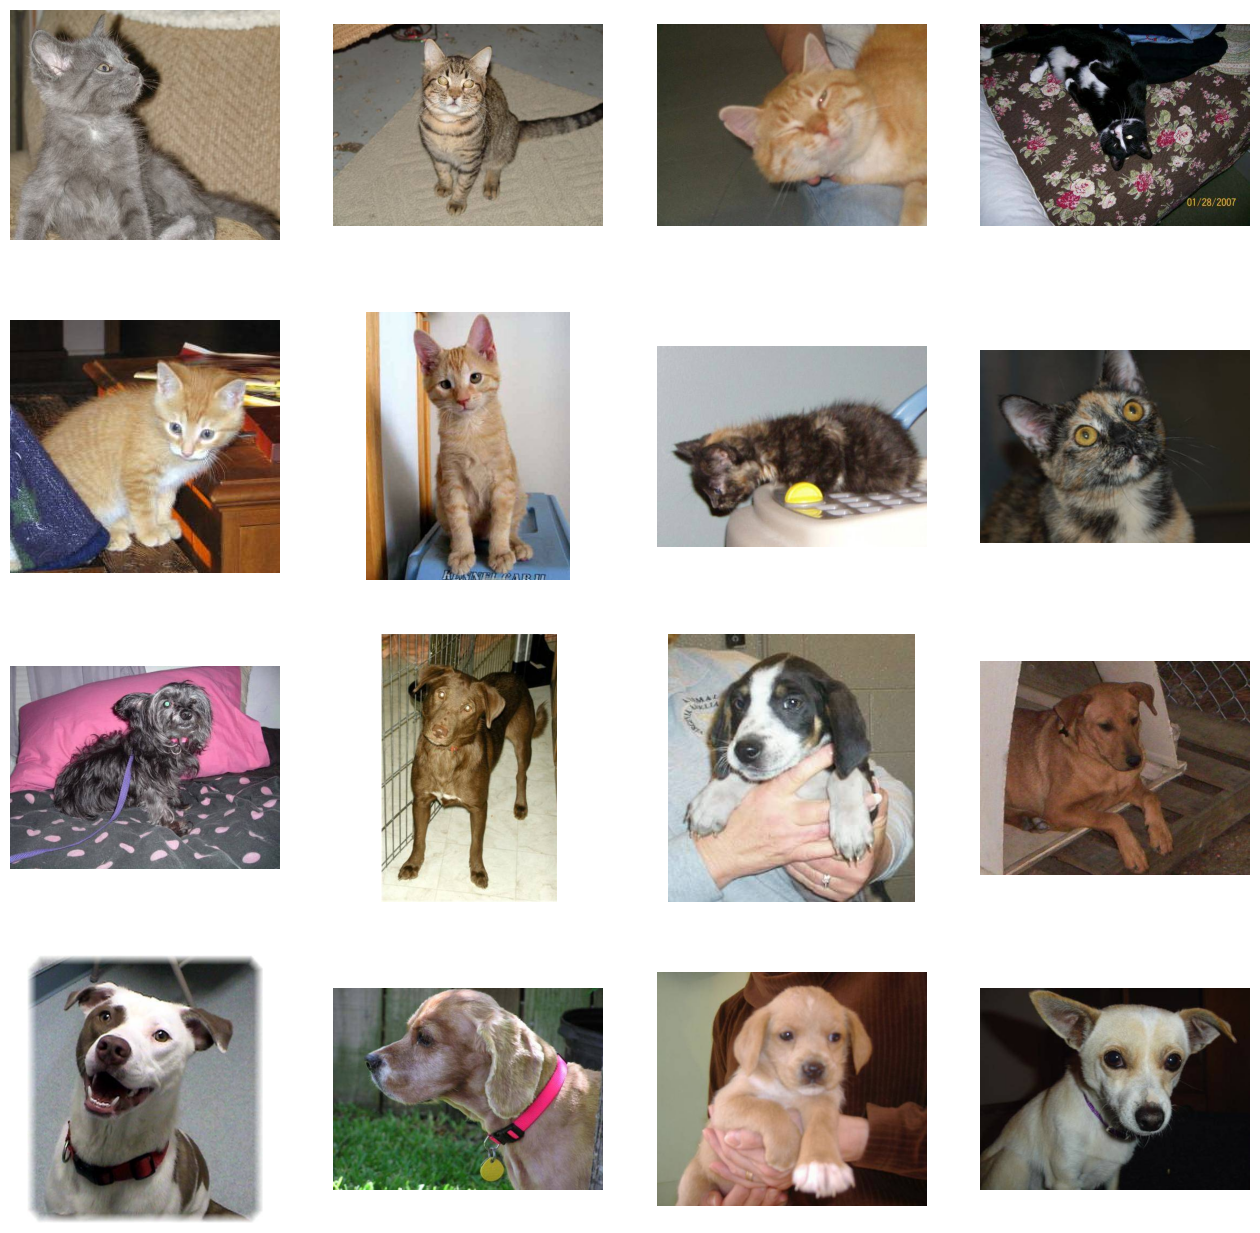

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building CNN based Neural Network

These are the imports for the libraries necessary for our models.

In [8]:
# Install required libraries
# !pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.image as mpimg

# seed value
seed = 12

# Set fixed seed
torch.manual_seed(seed)

In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Define transforms for data preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

validation_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

### Baseline CNN

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Create a dummy input to find out the size after conv layers
        self._initialize_fc()

    def _initialize_fc(self):
        # Forward pass a dummy input to calculate the flatten size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)  # Batch size 1, 3 channels, 150x150
            dummy_output = self.pool(torch.relu(self.conv2(self.pool(torch.relu(self.conv1(dummy_input))))))
            flattened_size = dummy_output.view(-1).shape[0]

        # Define fully connected layers based on this calculated size
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

    def name(self):
        return "SimpleCNN"

### CNN 2 Conv Layers

In [12]:
class CNNv2(nn.Module):
    def __init__(self):
        super(CNNv2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Initialize fully connected layers
        self._initialize_fc()

    def _initialize_fc(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            dummy_output = self.pool(torch.relu(self.bn2(self.conv2(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn3(self.conv3(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn4(self.conv4(dummy_output))))
            dummy_output = self.pool(torch.relu(self.bn5(self.conv5(dummy_output))))
            flattened_size = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool(torch.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def name(self):
        return "CNNv2"

### Setting hyperparameters

In [13]:
# Set model
model = CNNv2().to(device)

# Define hyperparameters
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 32
epochs = 100

# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(validation_dir, transform=validation_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, worker_init_fn=np.random.seed(seed))
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False, worker_init_fn=np.random.seed(seed))

# Get a batch from train_loader and get shape
image, _ = next(iter(train_loader))
print(f"Image shape: {image.shape}")

model

Image shape: torch.Size([32, 3, 150, 150])


CNNv2(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_feat

### Training and Evaluating the model

Model: CNNv2



Epoch 1, Loss: 0.981763


Epoch 2, Loss: 0.733902


Epoch 3, Loss: 0.665964


Epoch 4, Loss: 0.657355


Epoch 5, Loss: 0.626009


Epoch 6, Loss: 0.613530


Epoch 7, Loss: 0.600502


Epoch 8, Loss: 0.549895


Epoch 9, Loss: 0.526448


Epoch 10, Loss: 0.517115


Epoch 11, Loss: 0.504563


Epoch 12, Loss: 0.459525


Epoch 13, Loss: 0.426885


Epoch 14, Loss: 0.426466


Epoch 15, Loss: 0.388222


Epoch 16, Loss: 0.360536


Epoch 17, Loss: 0.323507


Epoch 18, Loss: 0.336615


Epoch 19, Loss: 0.296918


Epoch 20, Loss: 0.270744


Epoch 21, Loss: 0.264432


Epoch 22, Loss: 0.243460


Epoch 23, Loss: 0.214360


Epoch 24, Loss: 0.233383


Epoch 25, Loss: 0.188684


Epoch 26, Loss: 0.175385


Epoch 27, Loss: 0.187462


Epoch 28, Loss: 0.157868


Epoch 29, Loss: 0.128375


Epoch 30, Loss: 0.146163


Epoch 31, Loss: 0.134747


Epoch 32, Loss: 0.117440


Epoch 33, Loss: 0.131615


Epoch 34, Loss: 0.144135


Epoch 35, Loss: 0.101935


Epoch 36, Loss: 0.083945


Epoch 37, Loss: 0.058534


Epoch 38, Loss: 0.053510


Epoch 39, Loss: 0.064967


Epoch 40, Loss: 0.058106


Epoch 41, Loss: 0.125514


Epoch 42, Loss: 0.069332


Epoch 43, Loss: 0.051600


Epoch 44, Loss: 0.043734


Epoch 45, Loss: 0.056131


Epoch 46, Loss: 0.041187


Epoch 47, Loss: 0.093711


Epoch 48, Loss: 0.069479


Epoch 49, Loss: 0.045480


Epoch 50, Loss: 0.033421


Epoch 51, Loss: 0.035269


Epoch 52, Loss: 0.058238


Epoch 53, Loss: 0.031274


Epoch 54, Loss: 0.024629


Epoch 55, Loss: 0.027725


Epoch 56, Loss: 0.010090


Epoch 57, Loss: 0.050909


Epoch 58, Loss: 0.029729


Epoch 59, Loss: 0.057503


Epoch 60, Loss: 0.036576


Epoch 61, Loss: 0.013589


Epoch 62, Loss: 0.030434


Epoch 63, Loss: 0.017420


Epoch 64, Loss: 0.030996


Epoch 65, Loss: 0.020098


Epoch 66, Loss: 0.010454


Epoch 67, Loss: 0.043412


Epoch 68, Loss: 0.040642


Epoch 69, Loss: 0.028559


Epoch 70, Loss: 0.022993


Epoch 71, Loss: 0.064605


Epoch 72, Loss: 0.029044


Epoch 73, Loss: 0.024687


Epoch 74, Loss: 0.015542


Epoch 75, Loss: 0.020904


Epoch 76, Loss: 0.014807


Epoch 77, Loss: 0.006773


Epoch 78, Loss: 0.014838


Epoch 79, Loss: 0.044848


Epoch 80, Loss: 0.014702


Epoch 81, Loss: 0.002501


Epoch 82, Loss: 0.001859


Epoch 83, Loss: 0.035440


Epoch 84, Loss: 0.058609


Epoch 85, Loss: 0.023064


Epoch 86, Loss: 0.027759


Epoch 87, Loss: 0.007804


Epoch 88, Loss: 0.012177


Epoch 89, Loss: 0.006869


Epoch 90, Loss: 0.025063


Epoch 91, Loss: 0.017340


Epoch 92, Loss: 0.007546


Epoch 93, Loss: 0.011779


Epoch 94, Loss: 0.022781


Epoch 95, Loss: 0.025371


Epoch 96, Loss: 0.047415


Epoch 97, Loss: 0.012164


Epoch 98, Loss: 0.017599


Epoch 99, Loss: 0.026215


Epoch 100, Loss: 0.005686
Execution time: 18.87 minutes
Avg time per epoch: 0.19 minutes



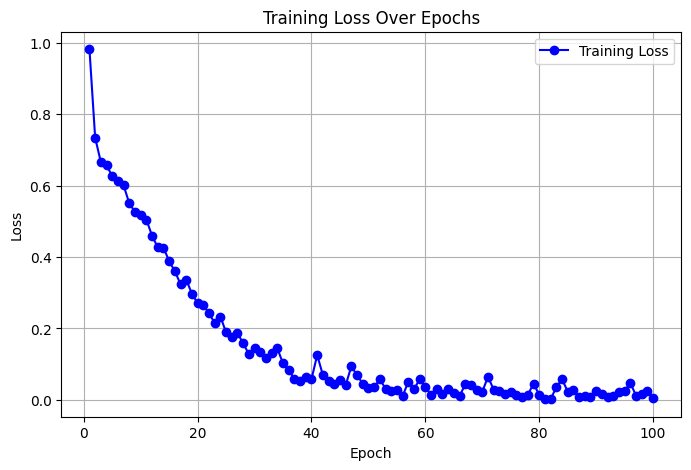


Validation Accuracy: 88.20%


In [14]:
import time

start_time = time.perf_counter()
loss_values = []

print(f"Model: {model.name()}\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_values.append(running_loss/len(train_loader))

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.6f}")

end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Execution time: {(execution_time)/60:.2f} minutes")
print(f"Avg time per epoch: {((execution_time/epochs)/60):.2f} minutes")

# Plot the loss graph
print()
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(validation_loader, leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nValidation Accuracy: {100 * correct / total:.2f}%')

# Test Your Model

Let's first save the trained model as a `pth` file.

In [17]:
torch.save(model.state_dict(), 'my_model.pth')

from google.colab import files
files.download('my_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
import os
import zipfile
import requests
from io import BytesIO

# Download the zip file from the URL
url = "https://happy-research.s3.ap-southeast-1.amazonaws.com/test-cats-vs-dogs.zip"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes

# Create a zip file object from the downloaded content
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extract the zip file to a temporary directory
zip_file.extractall("/content/")

# Define the paths to the extracted image directories
base_dir = "/content/test"
cats_dir = os.path.join(base_dir, "cats")
dogs_dir = os.path.join(base_dir, "dogs")


# Function to process the images
def process_images(directory):
    """
    Reads through each folder of images and returns a dataset.
    """
    image_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            filepath = os.path.join(directory, filename)
            # Perform any image preprocessing or feature extraction here.
            # For now, just store the filename
            image_data.append(filepath)
    return image_data

# Create Datasets for Cats and Dogs
cats_dataset = process_images(cats_dir)
dogs_dataset = process_images(dogs_dir)

# Now you have two lists: cats_dataset and dogs_dataset
# Each list contains the filepaths of the images within their corresponding folders.

print("Number of cat images:", len(cats_dataset))
print("Number of dog images:", len(dogs_dataset))
# Example access to individual image filepaths
print("First cat image:", cats_dataset[0])
print("First dog image:", dogs_dataset[0])

Number of cat images: 1
Number of dog images: 1
First cat image: /content/test/cats/cat-test-1.jpg
First dog image: /content/test/dogs/dog-test-1.jpg


In [20]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os

# Load the trained model
model = CNNv2().to(device)  # Assuming 'device' and 'SimpleCNN' are defined as in the previous code
model.load_state_dict(torch.load('my_model.pth'))
model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Function to predict the class of an image
def predict_image(image_path):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)
    return predicted_class.item()

# Directories
base_dir = "/content/test"
cats_dir = os.path.join(base_dir, "cats")
dogs_dir = os.path.join(base_dir, "dogs")

# Evaluate the model on the test dataset
correct_predictions = 0
total_images = 0

print("Predictions:")

for directory, label in [(cats_dir, 0), (dogs_dir, 1)]:
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            prediction = predict_image(image_path)
            total_images += 1
            if prediction == label:
              correct_predictions += 1

            print(f"Image: {filename}, Predicted: {'Cat' if prediction == 0 else 'Dog'}, Actual: {'Cat' if label == 0 else 'Dog'}")

accuracy = (correct_predictions / total_images) * 100
print(f"\nOverall Accuracy: {accuracy:.2f}%")


Predictions:
Image: cat-test-1.jpg, Predicted: Cat, Actual: Cat
Image: dog-test-1.jpg, Predicted: Dog, Actual: Dog

Overall Accuracy: 100.00%


<ipython-input-20-d04d4d73a341>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('my_model.pth'))


## Class Presentation

In [29]:
import os
import zipfile
import requests
from io import BytesIO

# Download the zip file from the URL
url = "https://happy-research.s3.ap-southeast-1.amazonaws.com/cats-vs-dogs-benchmark.zip"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes

# Create a zip file object from the downloaded content
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extract the zip file to a temporary directory
zip_file.extractall("/content/")

# Define the paths to the extracted image directories
base_dir = "/content/cats-vs-dogs-benchmark"
cats_dir = os.path.join(base_dir, "cats")
dogs_dir = os.path.join(base_dir, "dogs")


# Function to process the images
def process_images(directory):
    """
    Reads through each folder of images and returns a dataset.
    """
    image_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            filepath = os.path.join(directory, filename)
            # Perform any image preprocessing or feature extraction here.
            # For now, just store the filename
            image_data.append(filepath)
    return image_data

# Create Datasets for Cats and Dogs
cats_dataset = process_images(cats_dir)
dogs_dataset = process_images(dogs_dir)

# Now you have two lists: cats_dataset and dogs_dataset
# Each list contains the filepaths of the images within their corresponding folders.

print("Number of cat images:", len(cats_dataset))
print("Number of dog images:", len(dogs_dataset))
# Example access to individual image filepaths
print("First cat image:", cats_dataset[0])
print("First dog image:", dogs_dataset[0])

Number of cat images: 10
Number of dog images: 10
First cat image: /content/cats-vs-dogs-benchmark/cats/cat-7.jpg
First dog image: /content/cats-vs-dogs-benchmark/dogs/dog-9.jpg


In [30]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os

# Load the trained model
model = CNNv2().to(device)  # Assuming 'device' and 'SimpleCNN' are defined as in the previous code
model.load_state_dict(torch.load('my_model.pth'))
model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Function to predict the class of an image
def predict_image(image_path):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)
    return predicted_class.item()

# Directories
base_dir = "/content/cats-vs-dogs-benchmark"
cats_dir = os.path.join(base_dir, "cats")
dogs_dir = os.path.join(base_dir, "dogs")

# Evaluate the model on the test dataset
correct_predictions = 0
total_images = 0

print("Predictions:")

for directory, label in [(cats_dir, 0), (dogs_dir, 1)]:
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            prediction = predict_image(image_path)
            total_images += 1
            if prediction == label:
              correct_predictions += 1

            print(f"Image: {filename}, Predicted: {'Cat' if prediction == 0 else 'Dog'}, Actual: {'Cat' if label == 0 else 'Dog'}")

accuracy = (correct_predictions / total_images) * 100
print(f"\nOverall Accuracy: {accuracy:.2f}%")

<ipython-input-30-b955a8e409ae>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('my_model.pth'))


Predictions:
Image: cat-7.jpg, Predicted: Dog, Actual: Cat
Image: cat-3.jpg, Predicted: Cat, Actual: Cat
Image: cat-2.jpg, Predicted: Cat, Actual: Cat
Image: cat-6.jpg, Predicted: Cat, Actual: Cat
Image: cat-10.jpg, Predicted: Cat, Actual: Cat
Image: cat-9.jpg, Predicted: Cat, Actual: Cat
Image: cat-8.jpg, Predicted: Cat, Actual: Cat
Image: cat-4.jpg, Predicted: Cat, Actual: Cat
Image: cat-1.jpg, Predicted: Dog, Actual: Cat
Image: cat-5.jpg, Predicted: Dog, Actual: Cat
Image: dog-9.jpg, Predicted: Dog, Actual: Dog
Image: dog-1.jpg, Predicted: Dog, Actual: Dog
Image: dog-7.jpg, Predicted: Dog, Actual: Dog
Image: dog-3.jpg, Predicted: Dog, Actual: Dog
Image: dog-2.jpg, Predicted: Dog, Actual: Dog
Image: dog-8.jpg, Predicted: Dog, Actual: Dog
Image: dog-6.jpg, Predicted: Cat, Actual: Dog
Image: dog-10.jpg, Predicted: Dog, Actual: Dog
Image: dog-5.jpg, Predicted: Dog, Actual: Dog
Image: dog-4.jpg, Predicted: Cat, Actual: Dog

Overall Accuracy: 75.00%


## Batchnorm and Dropout

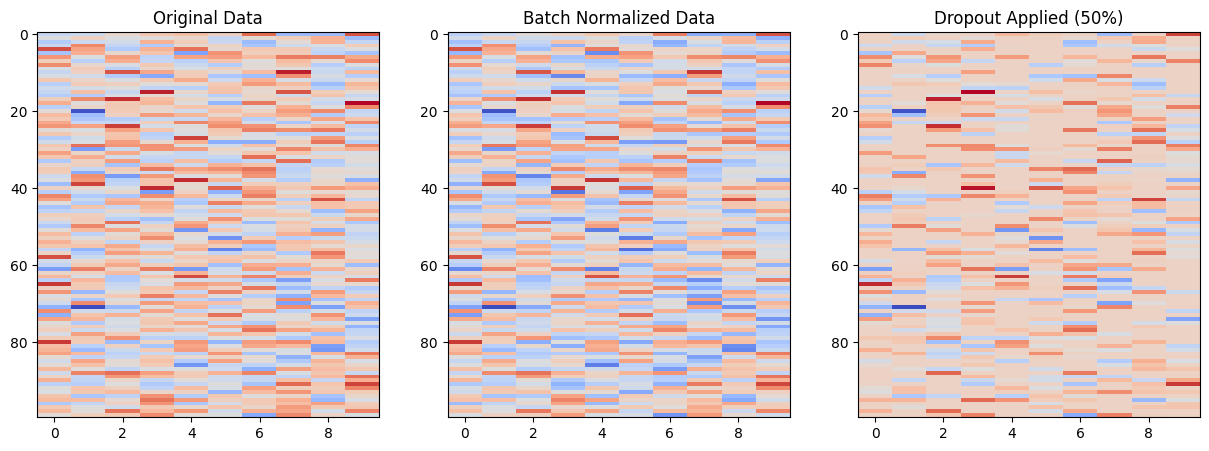

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Create dummy data
x = torch.randn(100, 10)  # 100 samples, 10 features

# Batch Normalization
bn = nn.BatchNorm1d(10)  # Apply batch normalization
x_bn = bn(x).detach()  # Get normalized output

# Dropout
dropout = nn.Dropout(0.5)  # 50% dropout
x_dropout = dropout(x).detach()  # Apply dropout

# Plot before and after
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x.numpy(), aspect='auto', cmap='coolwarm')
ax[0].set_title("Original Data")

ax[1].imshow(x_bn.numpy(), aspect='auto', cmap='coolwarm')
ax[1].set_title("Batch Normalized Data")

ax[2].imshow(x_dropout.numpy(), aspect='auto', cmap='coolwarm')
ax[2].set_title("Dropout Applied (50%)")

plt.show()
